# Homework 1 Stochastic Modeling 

## Demidov Maxim

In [303]:
import csv
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.patches import FancyArrowPatch, Circle
from numpy.random import RandomState
import collections
%matplotlib inline

Loading the data

In [304]:
f=open('MarkovChain1.csv', 'rU')
M=np.loadtxt(f,delimiter=',')
G = nx.DiGraph()
ebunch = []
shape = M.shape
for i in range(shape[0]):
    for j in range(shape[1]):
        if M[i][j] > 0:
            ebunch.append((i+1,j+1,M[i][j]))
G.add_weighted_edges_from(ebunch)
labels={}
for i in G.nodes():
    labels[i]=i



Drawing graph.Nodes are renamed 1 to 10, red edges are directed , the rest exist both ways with probabilities of transition closer to state

probabilities sum to one around each state

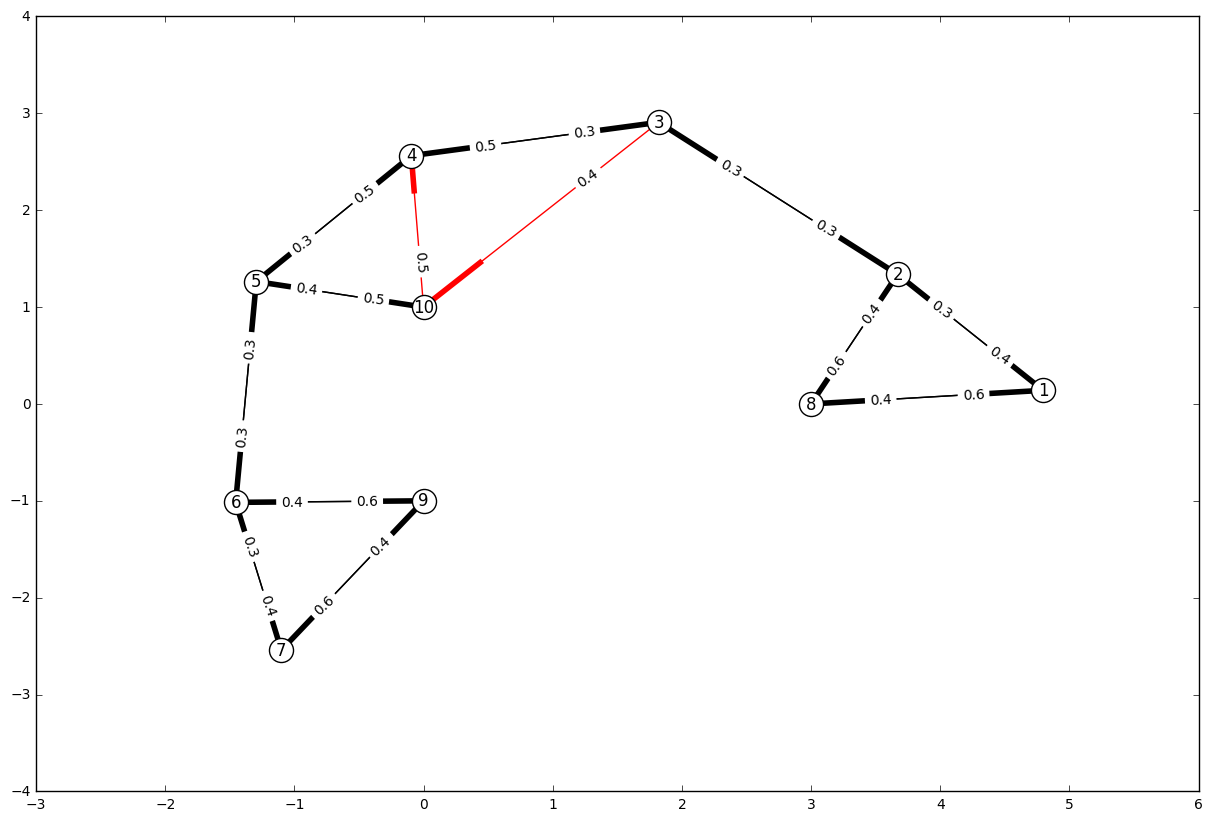

In [305]:
fixed_positions = {8:(3,0),10:(0,1),9:(0,-1)}
fixed_nodes = fixed_positions.keys()
edge_labels=dict([((u,v,),d['weight'])
                 for u,v,d in G.edges(data=True)])
red_edges=[]
for e in G.edges():
    if e[::-1] not in G.edges():
        red_edges.append(e)
edge_colors = ['black' if not edge in red_edges else 'red' for edge in G.edges()]

pos = nx.spring_layout(G,pos=fixed_positions, fixed = fixed_nodes)

plt.figure(1, figsize=(15,10))
nx.draw_networkx_labels(G,pos)
nx.draw_networkx_edge_labels(G,pos,edge_labels=edge_labels,label_pos=0.7)
nx.draw_networkx_nodes(G, pos, node_color='w')
nx.draw_networkx_edges(G, pos, edge_color=edge_colors, arrows=True)

### 1. Generating a sequence of states for this markov process.

In [306]:
#we assume initialisation node is uniformly distributed
#nodes are renumbered 1 to 10
def markov_walk(m,number=5,length=10,seed=1234):
    print 'Starting a sequence of %d walks of length %d' %(number,length)
    shape = m.shape
    rs=RandomState(seed)
    sequence=[]
    for i in range(number):
        node = rs.choice(range(shape[0]))
        walk = str(node+1)
        c=1
        while c in range(length):
            node=rs.choice(range(shape[0]),p=m[node])
            walk=walk+'->'+str(node+1)
            c+=1
        print walk
        
    
    

In [307]:
markov_walk(M,number=5,length=30,seed=1000)

Starting a sequence of 5 walks of length 30
4->3->10->4->3->10->4->3->2->8->2->8->2->1->2->8->2->1->8->1->8->2->8->1->8->2->8->1->8->2
2->1->8->2->8->2->1->2->8->1->8->1->8->2->1->8->2->3->10->5->10->4->5->10->4->3->10->4->5->10
3->4->3->4->5->6->7->9->7->9->6->7->9->7->9->6->7->9->6->9->6->7->9->7->9->6->9->6->7->6
6->9->6->7->9->6->9->6->9->6->5->10->5->10->4->5->10->5->4->3->10->5->4->3->4->3->10->4->5->4
2->8->2->3->2->1->8->2->8->1->2->8->2->1->2->8->2->8->2->8->1->8->2->1->8->2->3->2->8->1


### 2. Finding stationary distribution

from Fundamental Theorem of Markov chains we know that there exists: $ \lim_{m\to\infty} p_{ij}^{(m)} = \pi_j $

And from Kolmogorov-Chapman equasion we know that : $P_{ij}^{(m+k)} = \sum_{k=0}^\infty P_{ij}^m P_{ij}^k$ , and $P^{m+k} = P^m P^k $ , P being transition probability matrix.

Then, having a stationaty distribution $\Pi = [\pi_1,\pi_2,...,\pi_j]$, $\Pi = \Pi \cdot P$. Then it is an eigenvector problem with $\lambda = 1$

Now, let's receive the stationary probabilities vector

In [308]:
w,v =np.linalg.eig(np.transpose(M))
w = np.around(w,decimals=5)
num = w.tolist().index(1.0)
eighvec = v[:,num]
eighvec_n =  np.real(eighvec/sum(eighvec))

print eighvec_n


[ 0.05064295  0.08367095  0.08367095  0.11713933  0.15060772  0.15060772
  0.0911573   0.06385415  0.11493747  0.09371147]


Let's watch the convergence of the transition probability matrix to the stationary distribution:

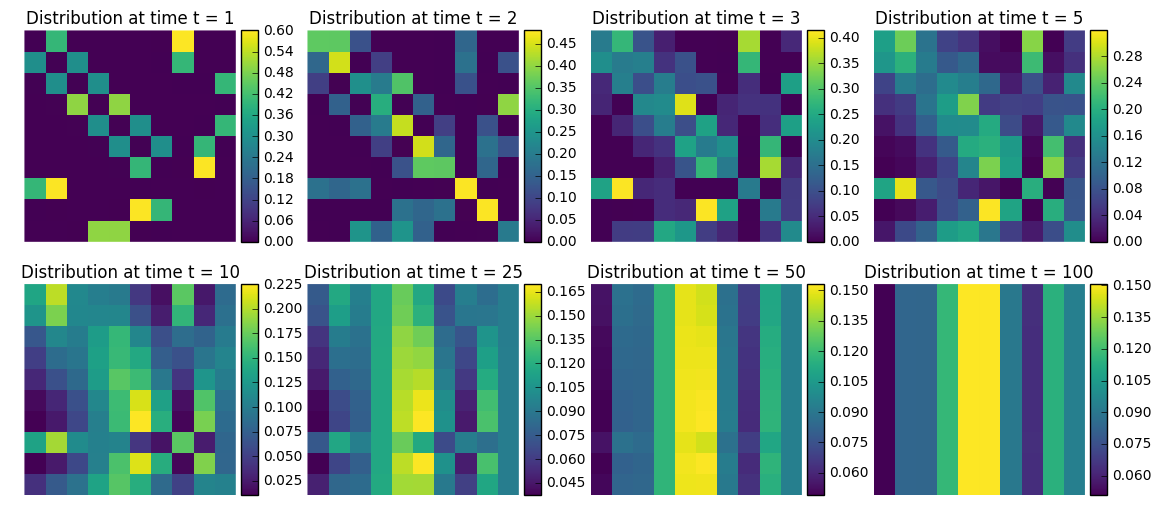

In [309]:
from mpl_toolkits.axes_grid1 import make_axes_locatable


fig, ax = plt.subplots(2,4,figsize=(14,6))
row=[1,2,3,5,10,25,50,100]
for i in range(8):
    A = np.linalg.matrix_power(M,row[i])
    vmin = np.amin(A)
    vmax = np.amax(A)
    im = ax[i // 4,i % 4].imshow(A,cmap=plt.cm.viridis, interpolation='None', vmin=vmin, vmax=vmax)
    ax[i // 4,i % 4].set_title('Distribution at time t = %d'% row[i]) 
    divider = make_axes_locatable(ax[i // 4,i % 4])
    cax = divider.append_axes("right", size="8%", pad=0.05)
    cbar = plt.colorbar(im, cax=cax)
    ax[i // 4,i % 4].axis('off')

We can observe graphically that indeed distribution converges to $\Pi = [\pi_1,\pi_2,...,\pi_j]$ , $ \pi_i $ being vectors of size 1 x n

Here we will try to emulate Markov process to check our theoretical assumptions. Here, and below i usually use 2 functions- first creates markov chain walks of set length. It is similar to function used in task #1.
second function counts transitions from node i to j of lenght t in those walks. As probability of transition does not change with time, we can collect a lot of data for calculating empirical transition probabilities from 1 (or several) long walks.

we count all pairs divided by t nodes in each walk

In [310]:
def markov_proc(m,number=5,length=10,seed=1234):
    shape = m.shape
    rs=RandomState(seed)
    sequence=[]
    for i in range(number):
        node = rs.choice(range(shape[0]))
        walk = np.zeros(length)
        c=0
        while c in range(length):
            node=rs.choice(range(shape[0]),p=m[node])
            walk[c] = int(node+1)
            c+=1
        sequence.append(walk)
    return sequence

In [311]:
def count_mc(processes,t,size = 10):
    transition =  np.zeros((size,size))
    walklength = len(processes[0])
    for r in processes:
        temp_matrix = np.zeros((size,size))
        enum = list(enumerate(r[:-t]))
        for num in range(1,size+1):
            entrys = np.array([place+t for place, node in enum if node == num])
            count = float(len(entrys))
            nodes = r[entrys]
            unique, counts = np.unique(nodes, return_counts=True)
            count_trans = dict(zip(unique, counts))
            for i in range(size):
                try:
                    temp_matrix[num-1][i] = count_trans[i+1] / count
                except KeyError:
                    temp_matrix[num-1][i] = 0.0
        transition = transition + temp_matrix
    return transition / float(len(processes))

We can observe the similar conversion towards stationary distribution for empirical transition probability.
We receive the empirical transition probability matrix by simulating markov process. t is number of steps

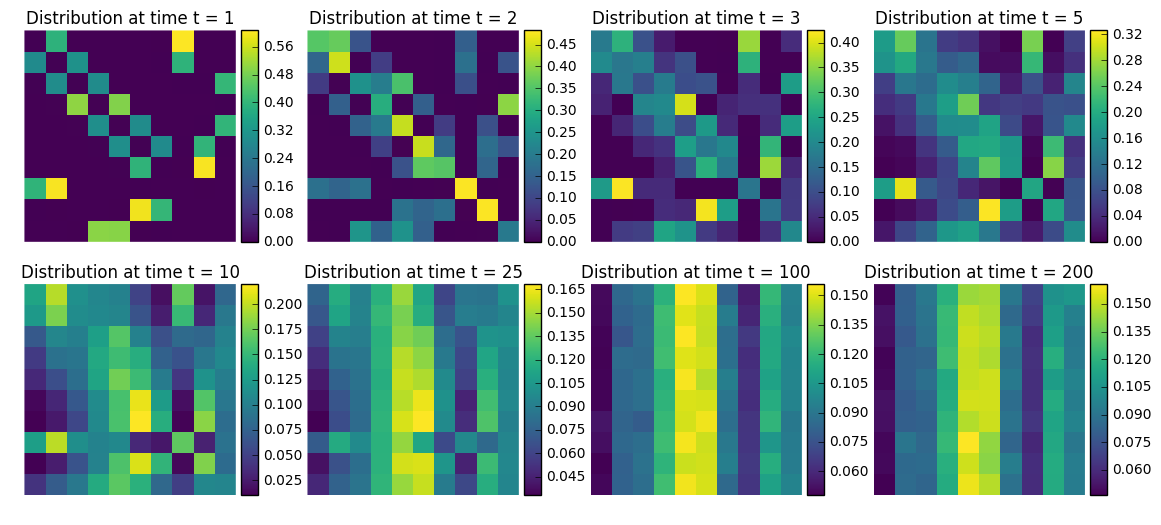

In [312]:
T = markov_proc(M,number=20,length=5100,seed=1000)

fig, ax = plt.subplots(2,4,figsize=(14,6))
row=[1,2,3,5,10,25,100,200]
for i in range(8):
    A = count_mc(T,row[i])
    vmin = np.amin(A)
    vmax = np.amax(A)
    im = ax[i // 4,i % 4].imshow(A,cmap=plt.cm.viridis, interpolation='None', vmin=vmin, vmax=vmax)
    ax[i // 4,i % 4].set_title('Distribution at time t = %d'% row[i]) 
    divider = make_axes_locatable(ax[i // 4,i % 4])
    cax = divider.append_axes("right", size="8%", pad=0.05)
    cbar = plt.colorbar(im, cax=cax)
    ax[i // 4,i % 4].axis('off')

In [313]:
def RMSE(x,y):
    a = np.reshape(x,-1)
    b = np.reshape(y,-1)
    rmse = np.sqrt(np.mean(map(lambda n, m: (n-m)**2,a,b)))
    return rmse
    

In [314]:
T = markov_proc(M,number=20,length=5100,seed=1000)
t = range(1,201)
f = np.zeros(200)
X = np.zeros((10,10))
for i in range(10):
    X[:,i].fill(eighvec_n[i])
for i in t:
    Y = count_mc(T,i)
    f[i-1] = RMSE(X,Y)

And here is conversion in terms of distance from steady state with number of steps. It would be very resource-consuming to run a simulation big enough for RMSE to reach near zero, but we can observe that it converges rather fast and rather good

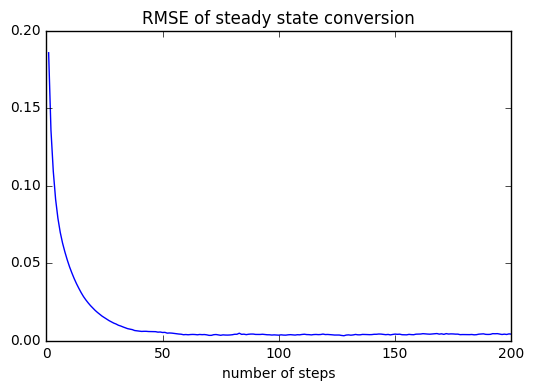

In [315]:
plt.figure(1)
ax = plt.subplot(111)
plt.title('RMSE of steady state conversion')
plt.xlabel('number of steps')
plt.plot(t,f)

## 3. Absorbing MC

loading data

In [316]:
file2=open('MarkovChain2.csv', 'r')
M2=np.loadtxt(file2,delimiter=',')
G2 = nx.DiGraph()
ebunch = []
shape = M2.shape
for i in range(shape[0]):
    for j in range(shape[1]):
        if M2[i][j] > 0:
            ebunch.append((i+1,j+1,M2[i][j]))
G2.add_weighted_edges_from(ebunch)
labels={}
for i in G2.nodes():
    labels[i]=i

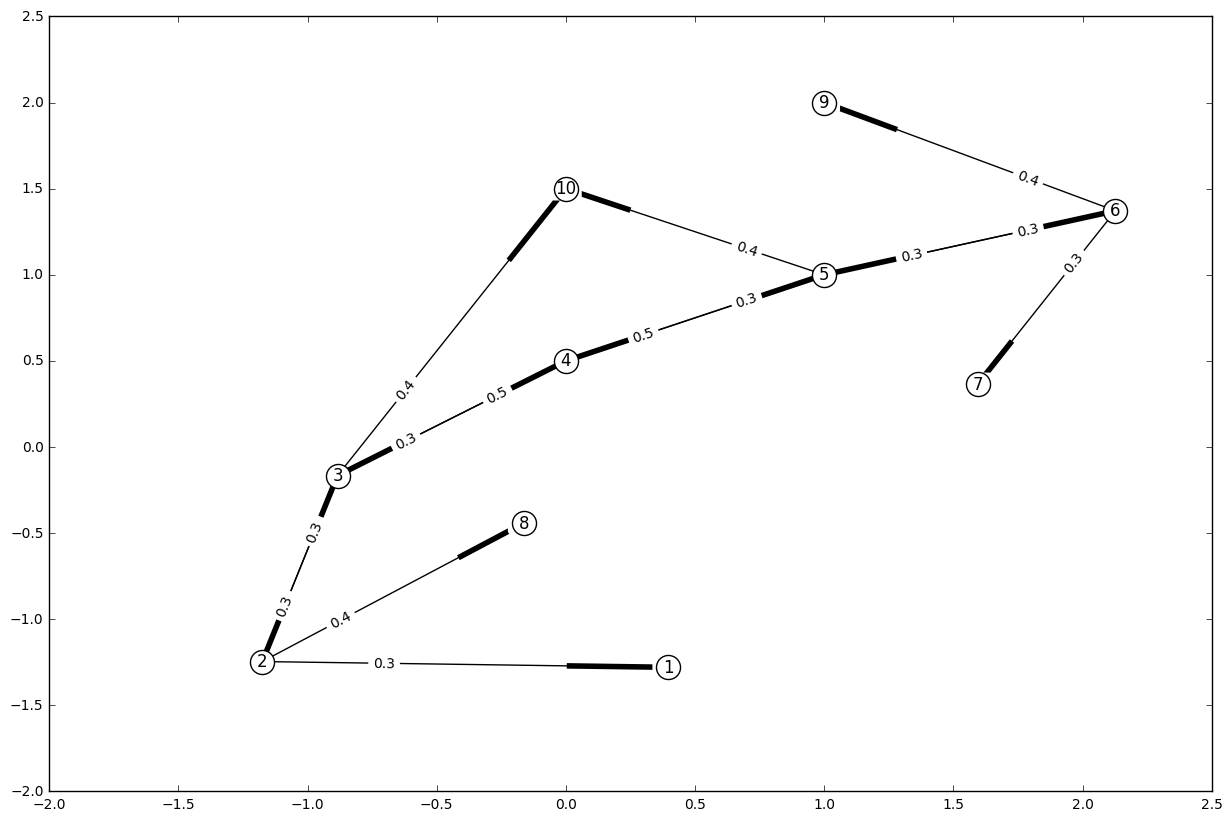

In [317]:
fixed_positions = {4:(0,0.5),5:(1,1),10:(0,1.5),9:(1,2)}
fixed_nodes = fixed_positions.keys()
edge_labels=dict([((u,v,),d['weight'])
                 for u,v,d in G2.edges(data=True)])
red_edges=[]
for e in G2.edges():
    if e[::-1] not in G2.edges():
        red_edges.append(e)
        
edge_colors = ['red' if edge in red_edges else 'black' for edge in G2.edges()]

pos = nx.spring_layout(G2,pos=fixed_positions, fixed = fixed_nodes)

plt.figure(1, figsize=(15,10))
nx.draw_networkx_labels(G2,pos)
nx.draw_networkx_edge_labels(G2,pos,edge_labels=edge_labels,label_pos=0.7 )
nx.draw_networkx_nodes(G2, pos, node_color='w')
nx.draw_networkx_edges(G2, pos,edge_colour = edge_colors, arrows=True)

As we have absorbing nodes, we can group them all together, rearranging transition matrix, so the matrix has block structure:
$$C= \left[ \begin{array}{c|c} I & 0 \\ \hline R & T \end{array} \right]$$
where I is Identity matrix (as absorbing nodes can only access itself), R-probability to be absorbed from transient node, and R-probability to move from 1 transient node to another.

From Kolmogorov-Chapman equasion we can write down probability to be absorbed by node a starting from node t as : $F_{ta} = R + RF_{ta} + TF_{ta}$. As $RF_{ta} = 0$ , we can rewrite equasion to receive our answer:
$$F_{ta} = (I-T)^{-1}R$$

We also can notice that matrix $ N = (I-T)^{-1}$ can be expressed as : $N_{i,j} = T_{i,j}^{(0)}+T_{i,j}^{(1)}+...+T_{i,j}^{(n)} $ and is expected number of visits from i to j. Summing up i'th row of matrix N gives us total expected number of nodes visited if starting from node i. (the expected time to absorbtion and absorbtion probabilities here depend on starting node, unlike case 2)

So we need to canculate matrices N and NR , which represent expected time to absobtion and probability of absorbtion to each node respectively.


From graph it is clear that nodes 1,7,8,9 and 10 are absorbing nodes

In [319]:
def reorder(m):
    X = m.copy()
    count = 0
    labels = dict([(x,x+1) for x in range(len(X))])
    for i in range(len(X)):
        if X[i][i] == 1:
            row = X[count].copy()
            X[count] = X[i]
            X[i] = row
            column = X[:,count].copy()
            X[:,count] = X[:,i]
            X[:,i] = column
            labels[i] = count+1
            labels[count] = i+1
            count +=1
    return X , labels ,count

In [321]:
M,labels,absorbing = reorder(M2)
N = np.linalg.inv((np.identity(5) - M[5:,5:]))
NR = np.linalg.inv((np.identity(5) - M[5:,5:])).dot(M[5:,:5])

Now we have computed theoretical parameters of stationary distribution.
below we can observe compact view of parameters and more detailed in form of the matrix.
The labels remain the same as in the original matrix, to make graph somewhat relatable.

In [322]:
print 'average theoretical absorbtion probability at time t->n '
print dict([(labels[t],round(sum(NR[:,t]/absorbing),3)) for t in range(absorbing)])
print 'Average time before absorbtion by starting node'
print dict([(labels[t+5],round(sum(N[t]),3)) for t in range(absorbing)])

average theoretical absorbtion probability at time t->n 
{8: 0.151, 1: 0.113, 10: 0.472, 9: 0.151, 7: 0.113}
Average time before absorbtion by starting node
{2: 1.787, 3: 2.623, 4: 3.623, 5: 2.623, 6: 1.787}


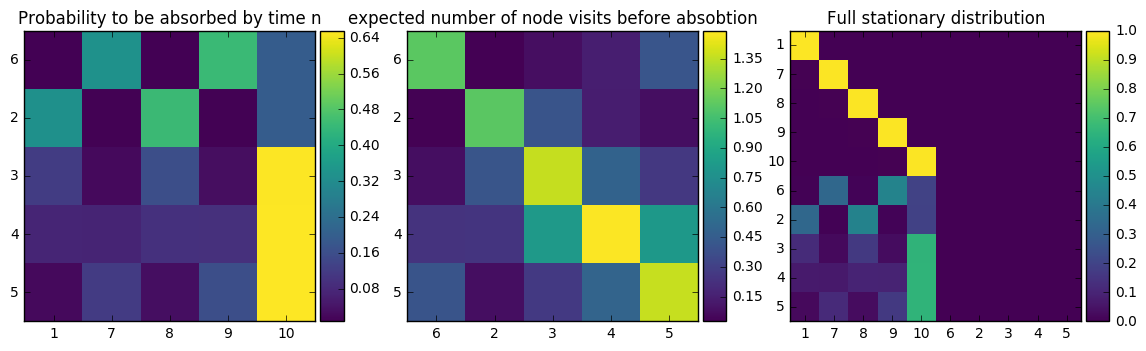

In [323]:
fig, ax = plt.subplots(1,3,figsize=(14,6))
im = ax[1].imshow(N,cmap=plt.cm.viridis, interpolation='None')
ax[1].set_title('expected number of node visits before absobtion') 
divider = make_axes_locatable(ax[1])
cax = divider.append_axes("right", size="8%", pad=0.05)
cbar = plt.colorbar(im, cax=cax)
ticks = range(5)
ax[1].set_xticks(np.arange(0,5,1))
ax[1].set_xticklabels([labels[i+5] for i in ticks])
ax[1].set_yticks(np.arange(0,5,1))
ax[1].set_yticklabels([labels[i+5] for i in ticks])

im = ax[0].imshow(NR,cmap=plt.cm.viridis, interpolation='None')
ax[0].set_title('Probability to be absorbed by time n') 
divider = make_axes_locatable(ax[0])
cax = divider.append_axes("right", size="8%", pad=0.05)
cbar = plt.colorbar(im, cax=cax)
ax[0].set_xticks(np.arange(0,5,1))
ax[0].set_xticklabels([labels[i] for i in ticks])
ax[0].set_yticks(np.arange(0,5,1))
ax[0].set_yticklabels([labels[i+5] for i in ticks])

Stationary = np.zeros((10,10))
Stationary[:5,:5] = np.identity(5)
Stationary[5:,:5] = NR
ticks2 = range(10)
im = ax[2].imshow(Stationary,cmap=plt.cm.viridis, interpolation='None')
ax[2].set_title('Full stationary distribution') 
divider = make_axes_locatable(ax[2])
cax = divider.append_axes("right", size="8%", pad=0.05)
cbar = plt.colorbar(im, cax=cax)
ax[2].set_xticks(np.arange(0,10,1))
ax[2].set_xticklabels([labels[i] for i in ticks2])
ax[2].set_yticks(np.arange(0,10,1))
ax[2].set_yticklabels([labels[i] for i in ticks2])

Left graph shows probabilities to be absorbed to each absorbing node(vertical axis) starting from each transient node.

Middle graph shows expected number of visits of each transient node before absorbtion starting from each transient node.

Right graph just show bigger picture, as we can see the left one being lower left block of stationary distribution matrix. (R in our notation) as t goes to n.

Matrix notation represent nodes in original graph 

In [324]:
def markov_proc(m,number=5,length=10,seed=1234):
    shape = m.shape
    rs=RandomState(seed)
    sequence=[]
    for i in range(number):
        node = rs.choice(range(shape[0]))
        walk = np.zeros(length+1)
        c=0
        while c in range(length+1):
            node=rs.choice(range(shape[0]),p=m[node])
            walk[c] = int(node)
            c+=1
        sequence.append(walk)
    return sequence

In [325]:
def count_mc(processes,t,size = 10):
    transition =  np.zeros((size,size))
    walklength = len(processes[0])
    for r in processes:
        temp_matrix = np.zeros((size,size))
        enum = list(enumerate(r[:-t]))
        for num in range(size):
            entrys = np.array([place+t for place, node in enum if node == num])
            count = float(len(entrys))
            if count == 0:
                pass
            else:
                nodes = r[entrys]
                unique, counts = np.unique(nodes, return_counts=True)
                count_trans = dict(zip(unique, counts))
                for i in range(size):
                    try:
                        temp_matrix[num][i] = count_trans[i] / float(count)
                    except KeyError:
                        temp_matrix[num][i] = 0.0
        transition = transition + temp_matrix
    for i in range(size):
        transition[i] = transition[i] / sum(transition[i])
    return transition 

As we have seen in previous task, theoretical and empirical distributions behave quite similarly, so we will only observe convergence of empirical one:


In [326]:
Matrix = []
for t in range(1,21):
    proc = markov_proc(M,number=5000,length=t+1,seed=1000)
    M_temp = count_mc(proc,t,size = 10)
    Matrix.append(M_temp)

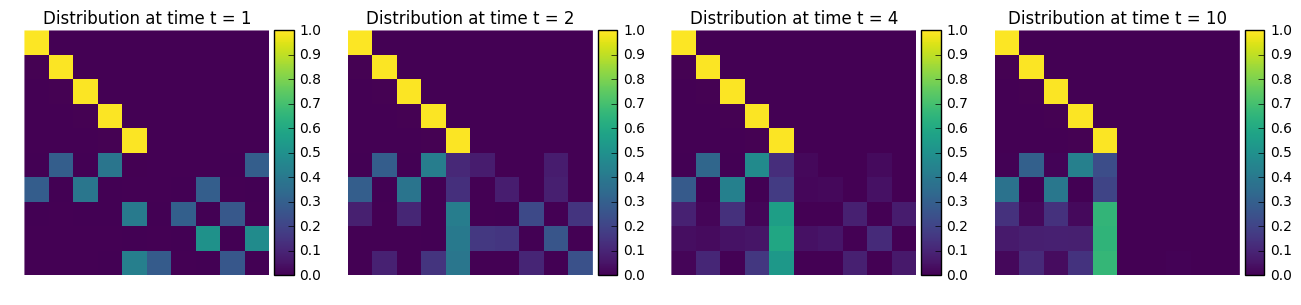

In [327]:
fig, ax = plt.subplots(1,4,figsize=(16,4))
row=[1,2,4,10]
for i in range(4):
    im = ax[i].imshow(Matrix[row[i]-1],cmap=plt.cm.viridis, interpolation='None')
    ax[i].set_title('Distribution at time t = %d'% row[i]) 
    divider = make_axes_locatable(ax[i])
    cax = divider.append_axes("right", size="8%", pad=0.05)
    cbar = plt.colorbar(im, cax=cax)
    ax[i].axis('off')

The empirical distribution behaves very much like the theoretical one. below we can see the graph of convergence towards stationary distribution.  It doesn't quite reach zero, as simulating cases of "almost zero probability" requires lots of computational power, still the general behavior of the graph is exactly as expected

In [328]:
t = range(1,21)
f = np.zeros(20)
X = Stationary
for i in t:
    Y = Matrix[i-1]
    f[i-1] = RMSE(X,Y)

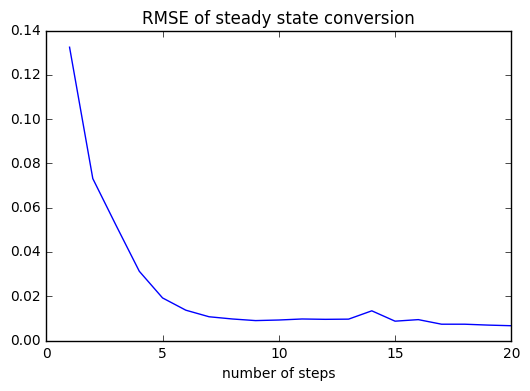

In [329]:
plt.figure(1)
ax = plt.subplot(111)
plt.title('RMSE of steady state conversion')
plt.xlabel('number of steps')
plt.plot(t,f)

Two usual functions used for counting time to absorption. Unlike task 1 and 2, we have to use of simulating long chains, as we do not care about what happens after absorbtion, so we generate quite a lot of small chains

In [330]:
def markov_e(m,number=200,seed=1234,absorbing = 5):
    shape = m.shape[0]
    rs=RandomState(seed)
    sequence=[]
    for i in range(number):
        node = rs.choice(range(absorbing,shape))
        walk = [node]
        c=0
        while True:
            node=rs.choice(range(shape),p=m[node])
            walk.append(int(node))
            c+=1
            if node < absorbing+1:
                break
        sequence.append(walk)
    return sequence

In [331]:
def count_e(processes,t,size = 5,absorbing = 5):
    transition =  np.zeros((size,size))
    temp_matrix = np.zeros((size,size))
    walklength = len(processes[0])
    counter = np.zeros(size)
    for r in processes:
        temp_matrix = np.zeros((size,size))
        num = r[0]
        counter[num-5] += 1
        length = min(len(r),t)
        nodes = r[:length]
        unique, counts = np.unique(nodes, return_counts=True)
        count_trans = dict(zip(unique, counts))
        for i in range(size+absorbing):
            try:
                temp_matrix[num-5][i-5] = count_trans[i]
            except KeyError:
                temp_matrix[num-5][i-5] = 0
            except IndexError:
                pass
        transition = transition + temp_matrix
    for i in range(size):
        transition[i] = transition[i] / float(counter[i])
    return transition 

finally, we can observe convergence of expected time to absorbtion to theoretically predicted result

In [332]:
Matrix = []
for t in range(1,21):
    e = markov_e(M,number=5000,seed=1000)
    M_temp = count_e(e,t)
    Matrix.append(M_temp)

In [333]:
t = range(1,21)
f = np.zeros(20)
X = N
for i in t:
    Y = Matrix[i-1]
    f[i-1] = RMSE(X,Y)

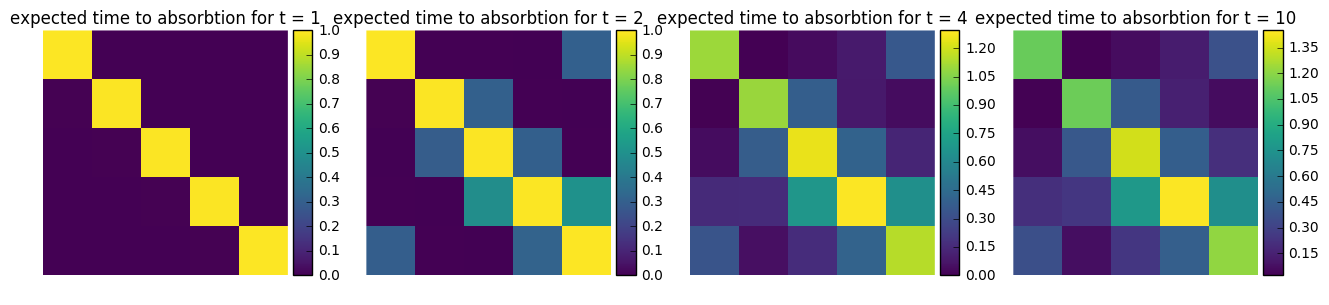

In [334]:
fig, ax = plt.subplots(1,4,figsize=(16,4))
ticks = range(5)
row=[1,2,4,10]
for i in range(4):
    
    im = ax[i].imshow(Matrix[row[i]-1],cmap=plt.cm.viridis, interpolation='None')
    ax[i].set_title('expected time to absorbtion for t = %d'% row[i]) 
    divider = make_axes_locatable(ax[i])
    cax = divider.append_axes("right", size="8%", pad=0.05)
    cbar = plt.colorbar(im, cax=cax)
    ax[i].axis('off')

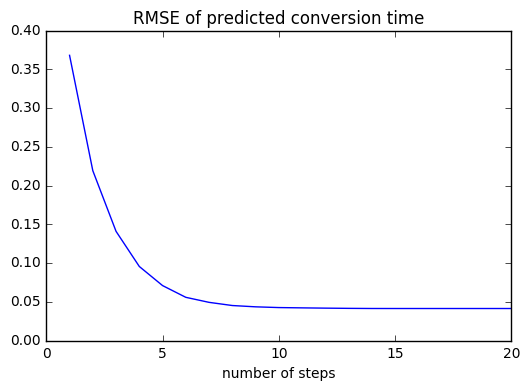

In [335]:
plt.figure(1)
ax = plt.subplot(111)
plt.title('RMSE of predicted conversion time')
plt.xlabel('number of steps')
plt.plot(t,f)